# HAT-P-7 b

In [292]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import sounddevice as sd # For playing audio
from scipy.io.wavfile import write as wav_write # For saving audio

%matplotlib inline

# Ensure sounddevice is configured (optional, usually works by default)
# print(sd.query_devices()) # List available devices
sd.default.samplerate = 44100 # Standard sample rate for audio
sd.default.channels = 1 # Mono audio

print(f"Default sample rate: {sd.default.samplerate} Hz")
print(f"Default channels: {sd.default.channels}")

Default sample rate: 44100 Hz
Default channels: [1, 1]


In [293]:
search_result_kepler = lk.search_lightcurve("HAT-P-7", author="Kepler", cadence="long", quarter = 4)
print("--- Kepler Search Result (HAT-P-7) ---")
search_result_kepler
# Assuming you want the first result if multiple are returned for Q4 by a specific author
print(f"Total results found: {len(search_result_kepler)}")
print("Downloading HAT-P-7 Quarter 4 data...")
lcf_kepler = search_result_kepler[0].download(quality_bitmask='default') 
print("\n--- Downloaded Kepler LightCurveFile ---")
print(lcf_kepler) 


--- Kepler Search Result (HAT-P-7) ---
Total results found: 1

--- Downloaded Kepler LightCurveFile ---
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
352.37711478692654            ——— ...  7.7506870e-02  6.9346622e-02
 352.3975477916392  1.0517504e+06 ...  7.7378429e-02  6.9265850e-02
 352.4384138016976  1.0516728e+06 ...  7.7436619e-02  6.9028609e-02
352.45884680699237  1.0516349e+06 ...  7.7292040e-02  6.8967402e-02
 352.4792798124545  1.0517338e+06 ...  7.7483147e-02  6.8901613e-02
 352.4997128180985  1.0517351e+06 ...  7.7358007e-02  6.8940714e-02
 352.5201458239753  1.0517264e+06 ...  7.7198587e-02  6.8944946e-02
352.54057872996054  1.0516392e+06 ...  7.7203348e-02  6.9013640e-02
 352.5610118361874  1.0516611e+06 ...  7.7151142e-02  6.8924069e-02
               ...            ... ...            ...            ...
442.01906800

Light curve processed.
14


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/2681203962.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)


<Figure size 1000x400 with 0 Axes>

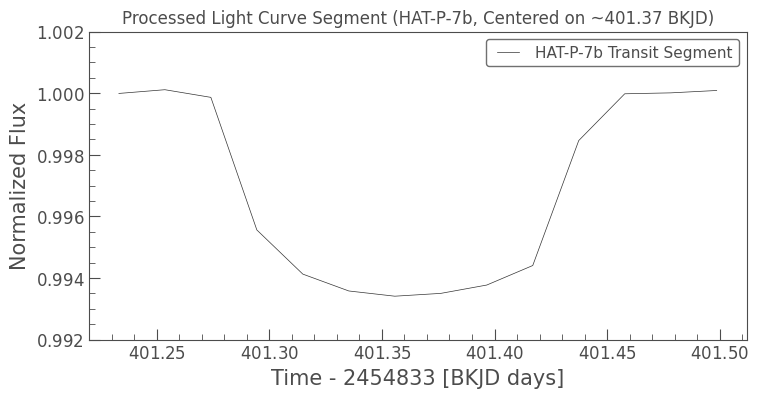

Selected 14 data points for sonification.


In [294]:


# Process the light curve: remove NaNs, normalize, flatten, remove outliers
lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)
print("Light curve processed.")


transit_center_time_bkjd = 401.368
transit_duration_days = 0.3

time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)
lc_transit_segment = lc_processed[time_mask]
print(len(lc_transit_segment.time))

plt.figure(figsize=(10, 4))
lc_transit_segment.plot(label="HAT-P-7b Transit Segment")
plt.title(f"Processed Light Curve Segment (HAT-P-7b, Centered on ~{transit_center_time_bkjd:.2f} BKJD)")
plt.ylim(0.992, 1.002) # Zoom in on y-axis to see transit clearly
plt.show()

flux_data = lc_transit_segment.flux.value
time_data = lc_transit_segment.time.value # We'll use this to set note timings
print(f"Selected {len(flux_data)} data points for sonification.")

In [295]:
sample_rate = 44100  # samples per second (standard CD quality)
note_duration_sec = 0.15  # duration of the sound for each data point in seconds

print(f"Sample rate: {sample_rate} Hz")
print(f"Duration of each sound event: {note_duration_sec} s")

Sample rate: 44100 Hz
Duration of each sound event: 0.15 s


### normal 

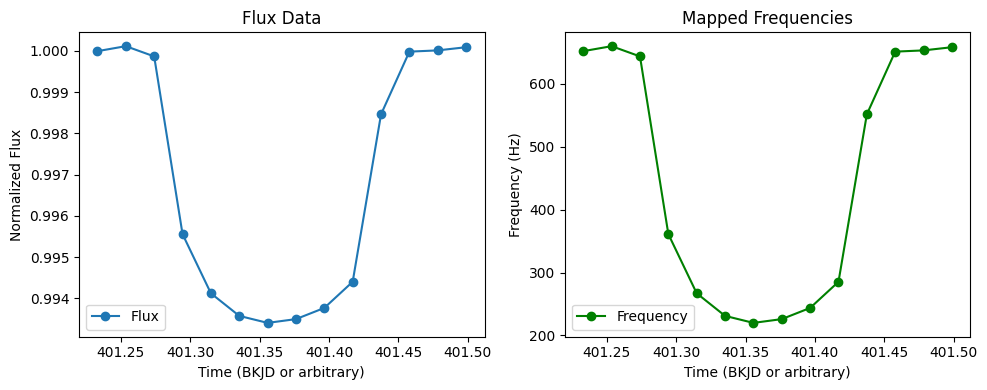

Flux range: 0.9934 to 1.0001
Frequency range: 220.00 Hz to 660.00 Hz


In [228]:
min_freq_hz = 220  # A3 note (low pitch)
max_freq_hz = 660  # E5 note (higher pitch, 1.5 octaves above A3)

# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (min_freq_hz, max_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

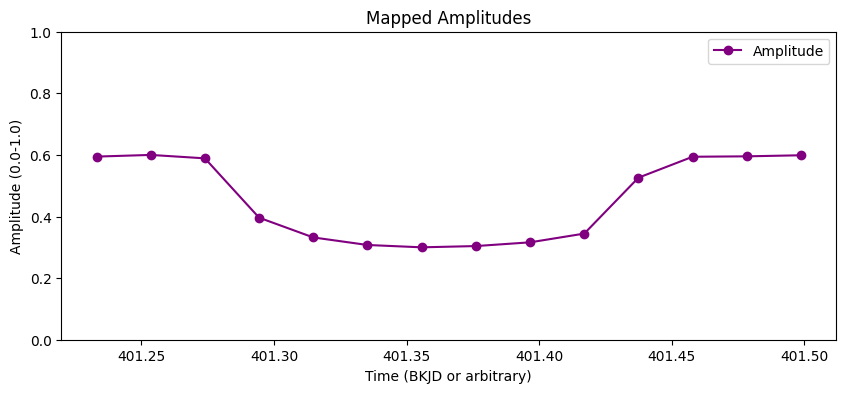

Amplitude range: 0.30 to 0.60


In [229]:
min_amplitude = 0.3  # Amplitude for the deepest part of the transit
max_amplitude = 0.6  # Amplitude for out-of-transit baseline

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_amplitude, max_amplitude]
# Lower flux will map to lower amplitude.
# (data_min_flux and data_max_flux are already checked to be different in the previous cell)
amplitudes = np.interp(flux_data, (data_min_flux, data_max_flux), (min_amplitude, max_amplitude))

# Plot the amplitude mapping
plt.figure(figsize=(10, 4))
plt.plot(time_data, amplitudes, 'o-', color='purple', label='Amplitude')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Amplitude (0.0-1.0)")
plt.title("Mapped Amplitudes")
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Amplitude range: {np.min(amplitudes):.2f} to {np.max(amplitudes):.2f}")

In [230]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 14 data points...
Audio signal generated and normalized.
Total duration of sonification: 2.10 seconds


In [234]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav


### inverse pitch + constant volume

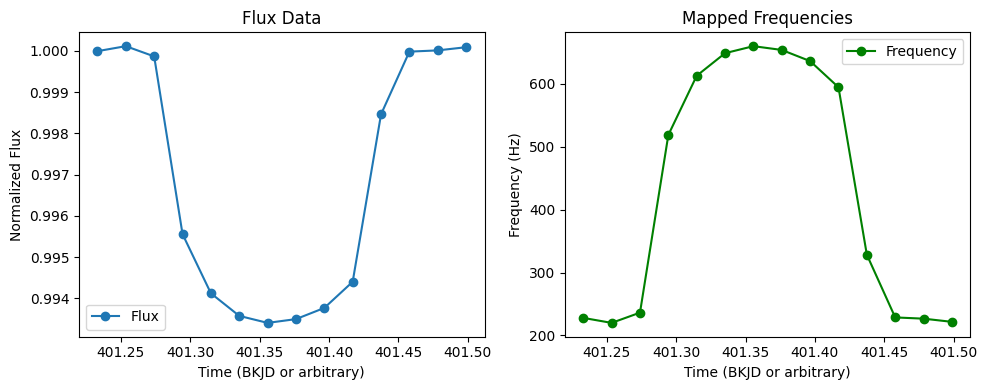

Flux range: 0.9934 to 1.0001
Frequency range: 220.00 Hz to 660.00 Hz


In [296]:
min_freq_hz = 220  # A3 note (low pitch)
max_freq_hz = 660  # E5 note (higher pitch, 1.5 octaves above A3)

# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (max_freq_hz, min_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

In [297]:
amplitudes = np.interp(flux_data, (data_min_flux, data_max_flux), (0.5, 0.5))


In [298]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 14 data points...
Audio signal generated and normalized.
Total duration of sonification: 2.10 seconds


In [299]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav


# Kepler-10 b

In [240]:
search_result_kepler = lk.search_lightcurve("Kepler-10", author="Kepler", cadence="long", quarter = 1)
print("--- Kepler Search Result (Kepler-10) ---")
search_result_kepler
print(f"Total results found: {len(search_result_kepler)}")
print("Downloading Kepler-10 Quarter 4 data...")
lcf_kepler = search_result_kepler[0].download(quality_bitmask='default') 
print("\n--- Downloaded Kepler LightCurveFile ---")
print(lcf_kepler) 

--- Kepler Search Result (Kepler-10) ---
Total results found: 1

--- Downloaded Kepler LightCurveFile ---
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
131.51231488081976  5.4414206e+05 ...  9.8826764e-03  3.9505973e-02
131.53274917569797  5.4417525e+05 ...  9.7936802e-03  3.9649725e-02
 131.5531833705827  5.4411431e+05 ...  9.9660996e-03  3.9738901e-02
131.57361746534298  5.4409756e+05 ...  1.0003630e-02  3.9322056e-02
131.59405165999488  5.4405306e+05 ...  9.6937595e-03  3.9238498e-02
131.61448595464753  5.4414344e+05 ...  9.6932473e-03  3.9064351e-02
131.63492004918226  5.4416519e+05 ...  9.6812742e-03  3.8814560e-02
131.65535424371046  5.4415406e+05 ...  9.4246082e-03  3.8896635e-02
 131.6757885381303  5.4416700e+05 ...  9.4989259e-03  3.8854126e-02
               ...            ... ...            ...            ...
 164.79948

Light curve processed.
15


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/4105213945.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)


<Figure size 1000x400 with 0 Axes>

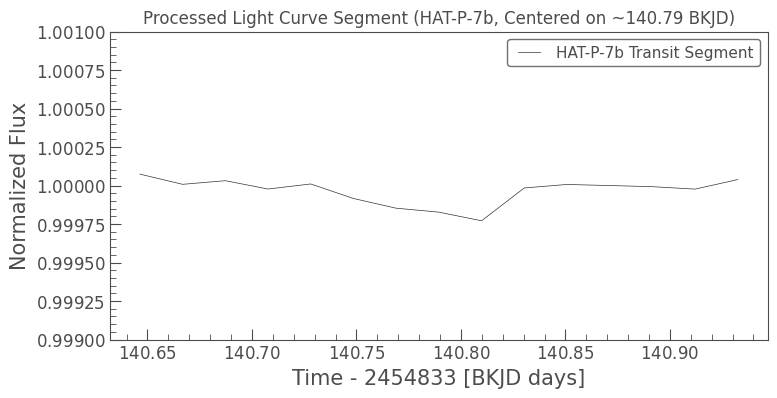

Selected 15 data points for sonification.


In [241]:
# Process the light curve: remove NaNs, normalize, flatten, remove outliers
lc_processed = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49).remove_outliers(sigma=5)
print("Light curve processed.")


transit_center_time_bkjd = 140.7869
transit_duration_days = 0.3

time_mask = (lc_processed.time.value > transit_center_time_bkjd - transit_duration_days / 2) & (lc_processed.time.value < transit_center_time_bkjd + transit_duration_days / 2)
lc_transit_segment = lc_processed[time_mask]
print(len(lc_transit_segment.time))

plt.figure(figsize=(10, 4))
lc_transit_segment.plot(label="HAT-P-7b Transit Segment")
plt.title(f"Processed Light Curve Segment (HAT-P-7b, Centered on ~{transit_center_time_bkjd:.2f} BKJD)")
plt.ylim(0.999, 1.001) # Zoom in on y-axis to see transit clearly
plt.show()

flux_data = lc_transit_segment.flux.value
time_data = lc_transit_segment.time.value # We'll use this to set note timings
print(f"Selected {len(flux_data)} data points for sonification.")

In [242]:
sample_rate = 44100  # samples per second (standard CD quality)
note_duration_sec = 0.15  # duration of the sound for each data point in seconds

print(f"Sample rate: {sample_rate} Hz")
print(f"Duration of each sound event: {note_duration_sec} s")

Sample rate: 44100 Hz
Duration of each sound event: 0.15 s


### normal

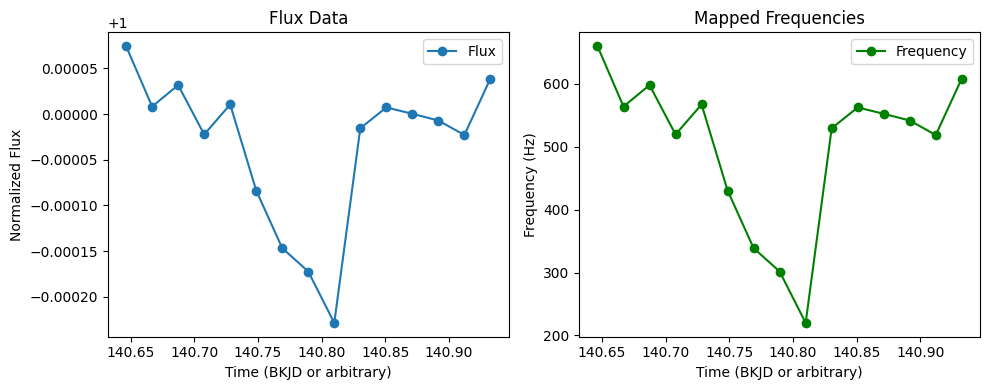

Flux range: 0.9998 to 1.0001
Frequency range: 220.00 Hz to 660.00 Hz


In [243]:
min_freq_hz = 220  # A3 note (low pitch)
max_freq_hz = 660  # E5 note (higher pitch, 1.5 octaves above A3)

# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (min_freq_hz, max_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

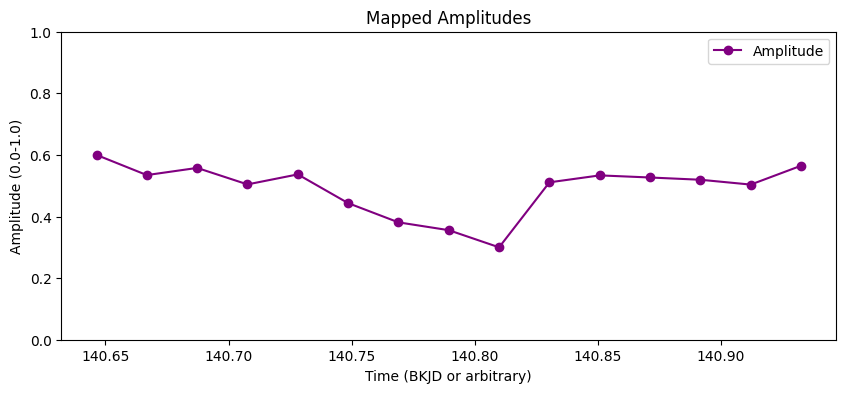

Amplitude range: 0.30 to 0.60


In [244]:
min_amplitude = 0.3  # Amplitude for the deepest part of the transit
max_amplitude = 0.6  # Amplitude for out-of-transit baseline

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_amplitude, max_amplitude]
# Lower flux will map to lower amplitude.
# (data_min_flux and data_max_flux are already checked to be different in the previous cell)
amplitudes = np.interp(flux_data, (data_min_flux, data_max_flux), (min_amplitude, max_amplitude))

# Plot the amplitude mapping
plt.figure(figsize=(10, 4))
plt.plot(time_data, amplitudes, 'o-', color='purple', label='Amplitude')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Amplitude (0.0-1.0)")
plt.title("Mapped Amplitudes")
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Amplitude range: {np.min(amplitudes):.2f} to {np.max(amplitudes):.2f}")

In [245]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 15 data points...
Audio signal generated and normalized.
Total duration of sonification: 2.25 seconds


In [247]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav


### higher frequency range + amplitude is louder during transit (+ larger range of amplitudes)

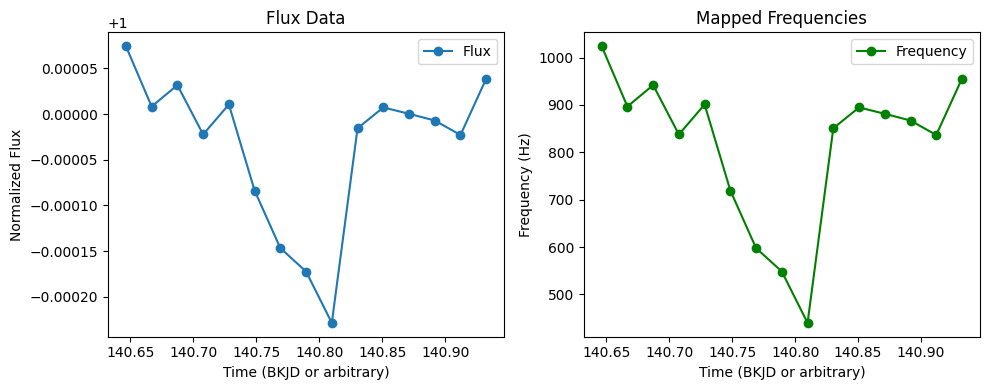

Flux range: 0.9998 to 1.0001
Frequency range: 440.00 Hz to 1024.00 Hz


In [248]:
min_freq_hz = 440  # A4 note 
max_freq_hz = 1024  # C6 note 
# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (min_freq_hz, max_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

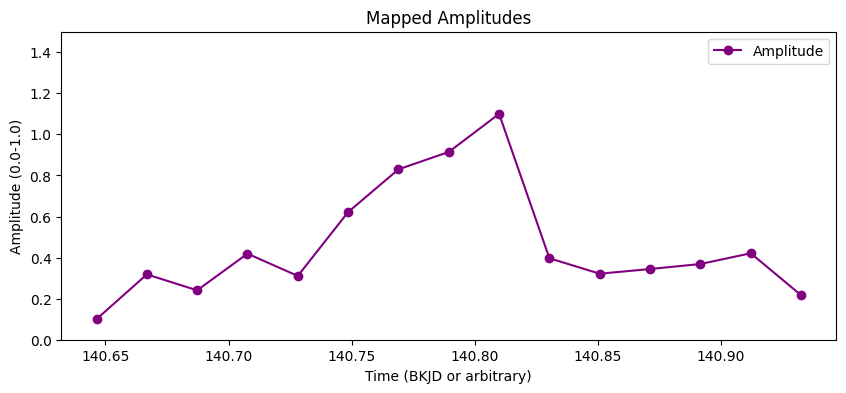

Amplitude range: 0.10 to 1.10


In [249]:
min_amplitude = 0.1  # Amplitude for the deepest part of the transit
max_amplitude = 1.1  # Amplitude for out-of-transit baseline

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_amplitude, max_amplitude]
# Lower flux will map to lower amplitude.
# (data_min_flux and data_max_flux are already checked to be different in the previous cell)
amplitudes = np.interp(flux_data, (data_min_flux, data_max_flux), (max_amplitude, min_amplitude))

# Plot the amplitude mapping
plt.figure(figsize=(10, 4))
plt.plot(time_data, amplitudes, 'o-', color='purple', label='Amplitude')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Amplitude (0.0-1.0)")
plt.title("Mapped Amplitudes")
plt.ylim(0, 1.5)
plt.legend()
plt.show()

print(f"Amplitude range: {np.min(amplitudes):.2f} to {np.max(amplitudes):.2f}")

In [250]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 15 data points...
Audio signal generated and normalized.
Total duration of sonification: 2.25 seconds


In [251]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav


# KOI-94 b

check this light curve

In [252]:
search_result_kepler = lk.search_lightcurve("KOI-94", author="Kepler", cadence="long", quarter = 1)
print("--- Kepler Search Result (KOI-94) ---")
search_result_kepler
print(f"Total results found: {len(search_result_kepler)}")
print("Downloading KOI-94 Quarter 1 data...")
lcf_kepler = search_result_kepler[0].download(quality_bitmask='default') 
print("\n--- Downloaded Kepler LightCurveFile ---")
print(lcf_kepler) 

--- Kepler Search Result (KOI-94) ---
Total results found: 2

--- Downloaded Kepler LightCurveFile ---
       time             flux      ...   pos_corr1      pos_corr2   
                    electron / s  ...      pix            pix      
------------------ -------------- ... -------------- --------------
 131.5120309185877  1.9197398e+05 ... -1.7320424e-02 -2.7222876e-02
131.53246556946397  1.9199506e+05 ... -1.7251583e-02 -2.7121808e-02
131.55290012023033  1.9195759e+05 ... -1.7319493e-02 -2.6948046e-02
131.57333457098866  1.9194900e+05 ... -1.7649889e-02 -2.6856938e-02
131.59376912175503  1.9197105e+05 ... -1.7224118e-02 -2.7370106e-02
131.61420377252216  1.9195006e+05 ... -1.7224355e-02 -2.7315572e-02
131.63463822317135  1.9194847e+05 ... -1.7242940e-02 -2.7341733e-02
131.65507277381403  1.9195381e+05 ... -1.6971098e-02 -2.7477572e-02
131.67550742434833  1.9196077e+05 ... -1.7144060e-02 -2.7403049e-02
               ...            ... ...            ...            ...
164.799791770

Light curve processed.
23


/var/folders/94/wcjh9dks4t39_w2np3l4nj0m0000gn/T/ipykernel_17369/3352019697.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lcf_kepler = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49)


<Figure size 1000x400 with 0 Axes>

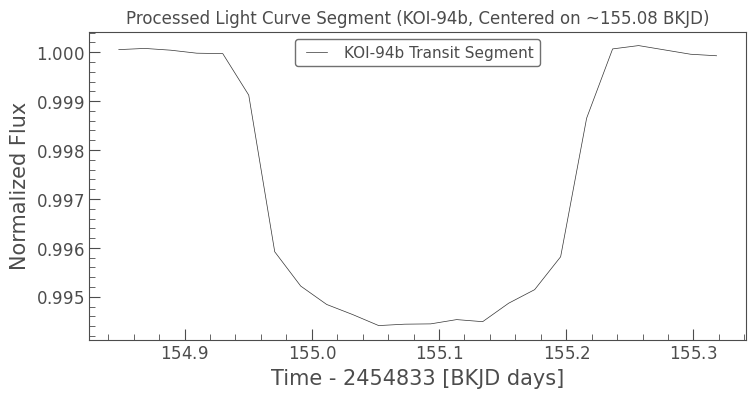

Selected 23 data points for sonification.


In [ ]:
# Process the light curve: remove NaNs, normalize, flatten
print("Light curve processed.")
lcf_kepler = lcf_kepler.PDCSAP_FLUX.remove_nans().normalize().flatten(window_length=49)

transit_center_time_bkjd = 155.08
transit_duration_days = 0.5

time_mask = (lcf_kepler.time.value > transit_center_time_bkjd - transit_duration_days / 2) & (lcf_kepler.time.value < transit_center_time_bkjd + transit_duration_days / 2)
lc_transit_segment = lcf_kepler[time_mask]
print(len(lc_transit_segment.time))

plt.figure(figsize=(10, 4))
lc_transit_segment.plot(label="KOI-94b Transit Segment")
plt.title(f"Processed Light Curve Segment (KOI-94b, Centered on ~{transit_center_time_bkjd:.2f} BKJD)")
plt.show()

flux_data = lc_transit_segment.flux.value
time_data = lc_transit_segment.time.value # We'll use this to set note timings
print(f"Selected {len(flux_data)} data points for sonification.")

### normal

In [254]:
sample_rate = 44100  # samples per second (standard CD quality)
note_duration_sec = 0.15  # duration of the sound for each data point in seconds

print(f"Sample rate: {sample_rate} Hz")
print(f"Duration of each sound event: {note_duration_sec} s")

Sample rate: 44100 Hz
Duration of each sound event: 0.15 s


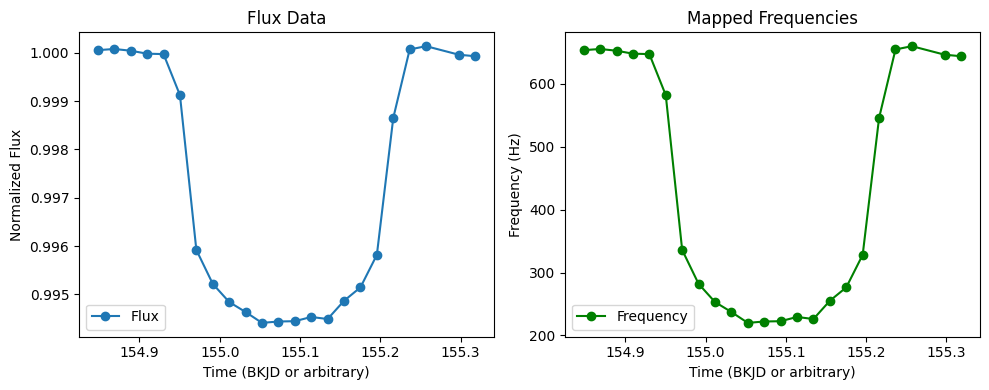

Flux range: 0.9944 to 1.0001
Frequency range: 220.00 Hz to 660.00 Hz


In [255]:
min_freq_hz = 220  # A3 note (low pitch)
max_freq_hz = 660  # E5 note (higher pitch, 1.5 octaves above A3)

# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (min_freq_hz, max_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

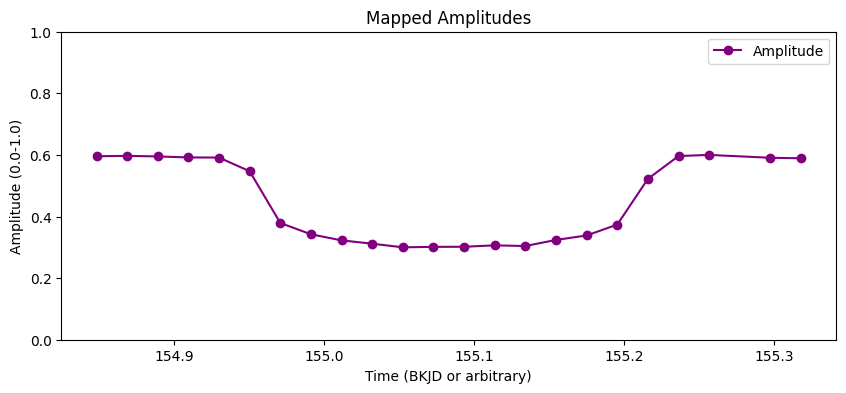

Amplitude range: 0.30 to 0.60


In [256]:
min_amplitude = 0.3  # Amplitude for the deepest part of the transit
max_amplitude = 0.6  # Amplitude for out-of-transit baseline

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_amplitude, max_amplitude]
# Lower flux will map to lower amplitude.
# (data_min_flux and data_max_flux are already checked to be different in the previous cell)
amplitudes = np.interp(flux_data, (data_min_flux, data_max_flux), (min_amplitude, max_amplitude))

# Plot the amplitude mapping
plt.figure(figsize=(10, 4))
plt.plot(time_data, amplitudes, 'o-', color='purple', label='Amplitude')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Amplitude (0.0-1.0)")
plt.title("Mapped Amplitudes")
plt.ylim(0, 1)
plt.legend()
plt.show()

print(f"Amplitude range: {np.min(amplitudes):.2f} to {np.max(amplitudes):.2f}")

In [257]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 23 data points...
Audio signal generated and normalized.
Total duration of sonification: 3.45 seconds


In [258]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav


### lower frequency range + longer note duration

In [259]:
sample_rate = 44100  # samples per second (standard CD quality)
note_duration_sec = 0.33  # duration of the sound for each data point in seconds

print(f"Sample rate: {sample_rate} Hz")
print(f"Duration of each sound event: {note_duration_sec} s")

Sample rate: 44100 Hz
Duration of each sound event: 0.33 s


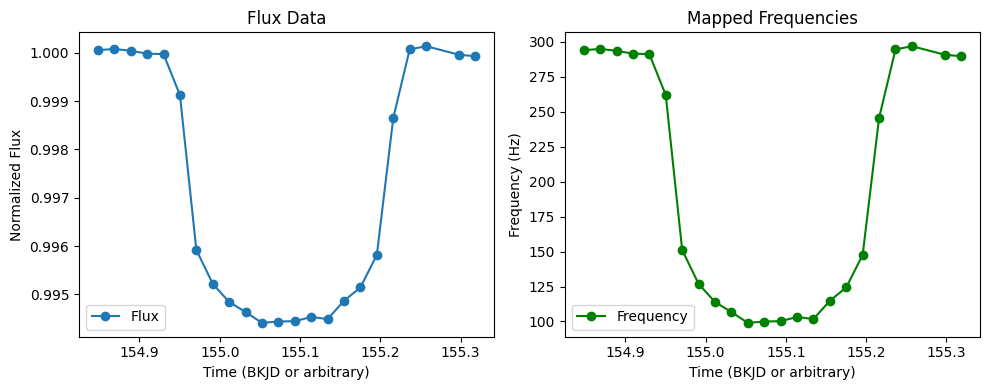

Flux range: 0.9944 to 1.0001
Frequency range: 99.00 Hz to 297.00 Hz


In [260]:
min_freq_hz = 99  # I don't even know what notes these are anymore
max_freq_hz = 297  #

# The flux_data is already normalized, with out-of-transit values around 1.0
# and in-transit values dipping below 1.0 (e.g., to ~0.994 for Kepler-8b).
data_min_flux = np.min(flux_data)
data_max_flux = np.max(flux_data) # This should be close to 1.0

# Ensure data_min_flux and data_max_flux are different to avoid division by zero or NaN in np.interp
if data_min_flux == data_max_flux:
    data_max_flux += 1e-9 # Add a tiny offset if all values are the same

# Linear interpolation: map [data_min_flux, data_max_flux] to [min_freq_hz, max_freq_hz]
# Lower flux will map to lower frequency.
frequencies = np.interp(flux_data, (data_min_flux, data_max_flux), (min_freq_hz, max_freq_hz))

# Let's plot the mapping to verify
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(time_data, flux_data, 'o-', label='Flux')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Normalized Flux")
plt.title("Flux Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(time_data, frequencies, 'o-', color='green', label='Frequency')
plt.xlabel("Time (BKJD or arbitrary)")
plt.ylabel("Frequency (Hz)")
plt.title("Mapped Frequencies")
plt.legend()

plt.tight_layout()
plt.show()

print(f"Flux range: {data_min_flux:.4f} to {data_max_flux:.4f}")
print(f"Frequency range: {np.min(frequencies):.2f} Hz to {np.max(frequencies):.2f} Hz")

In [261]:
total_samples_per_note = int(sample_rate * note_duration_sec)
t_note = np.linspace(0, note_duration_sec, total_samples_per_note, endpoint=False) # Time vector for one note

audio_signal_list = [] # Initialize a list to store individual note waves

print(f"Generating audio for {len(flux_data)} data points...")
for i in range(len(flux_data)):
    freq = frequencies[i]
    amp = amplitudes[i]

    # Generate sine wave for the current data point
    # y(t) = A * sin(2 * pi * f * t)
    current_note_wave = amp * np.sin(2 * np.pi * freq * t_note)

    # Apply a simple envelope (fade-in/fade-out) to each note to reduce clicking
    fade_duration_sec = 0.005 # 5ms fade
    fade_samples = int(sample_rate * fade_duration_sec)
    if total_samples_per_note > 2 * fade_samples: # Ensure note is long enough for fades
        fade_in_curve = np.linspace(0, 1, fade_samples)
        fade_out_curve = np.linspace(1, 0, fade_samples)
        current_note_wave[:fade_samples] *= fade_in_curve
        current_note_wave[-fade_samples:] *= fade_out_curve
    
    audio_signal_list.append(current_note_wave)

# Concatenate all note waves into a single audio signal
if audio_signal_list:
    audio_signal = np.concatenate(audio_signal_list)
else:
    audio_signal = np.array([0.0]) # Handle empty list (e.g., if flux_data was empty)

# Normalize the final audio signal to be between -1 and 1 (typical for audio)
# And scale it to avoid clipping (e.g., to 80% of max volume)
if len(audio_signal) > 0 and np.max(np.abs(audio_signal)) > 0:
    audio_signal_normalized = audio_signal / np.max(np.abs(audio_signal)) * 0.8
else:
    audio_signal_normalized = np.array([0.0]) # Handle empty or all-zero signal
    print("Warning: Audio signal is empty or all zeros after generation.")

print("Audio signal generated and normalized.")
print(f"Total duration of sonification: {len(audio_signal_normalized)/sample_rate:.2f} seconds")

Generating audio for 23 data points...
Audio signal generated and normalized.
Total duration of sonification: 7.59 seconds


In [263]:
if len(audio_signal_normalized) > 1: # sounddevice needs more than one sample
    print("Playing sonified transit data...")
    sd.play(audio_signal_normalized, sample_rate)
    sd.wait()  # Wait until playback is finished
    print("Playback complete.")

    # Optional: Save as a WAV file
    try:
        wav_filename = "sonified_transit_segment.wav"
        audio_array = np.array(audio_signal_normalized.filled(0))
        # Scale to 16-bit integer range if saving as standard WAV
        audio_to_save = np.int16(audio_array * 32767)
        wav_write(wav_filename, sample_rate, audio_to_save)
        print(f"Audio saved as {wav_filename}")
    except Exception as e:
        print(f"Error saving WAV file: {e}")
else:
    print("Audio signal too short to play or save.")

Playing sonified transit data...
Playback complete.
Audio saved as sonified_transit_segment.wav
